<a href="https://colab.research.google.com/github/Maithili-Badhan/Minor_Project/blob/maithili_branch/Chest_X_Ray_Images_(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setting up Kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
#Downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:44<00:00, 22.4MB/s]
100% 2.29G/2.29G [01:44<00:00, 23.7MB/s]


In [4]:
#Unzipping the dataset
import zipfile

zip_data = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
zip_data.extractall()
zip_data.close()

# Importing Libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

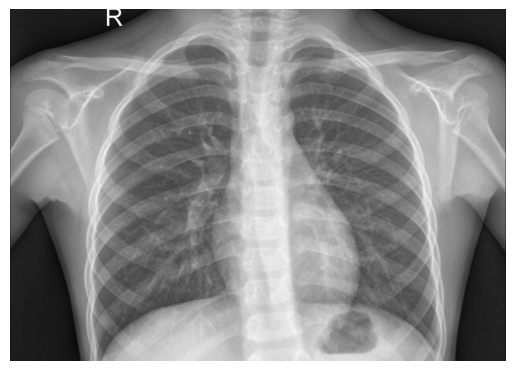

In [6]:
# Read the image using OpenCV
img = cv2.imread('/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

# Convert BGR to RGB (Matplotlib expects RGB format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()

In [7]:
img.shape

(1317, 1857, 3)

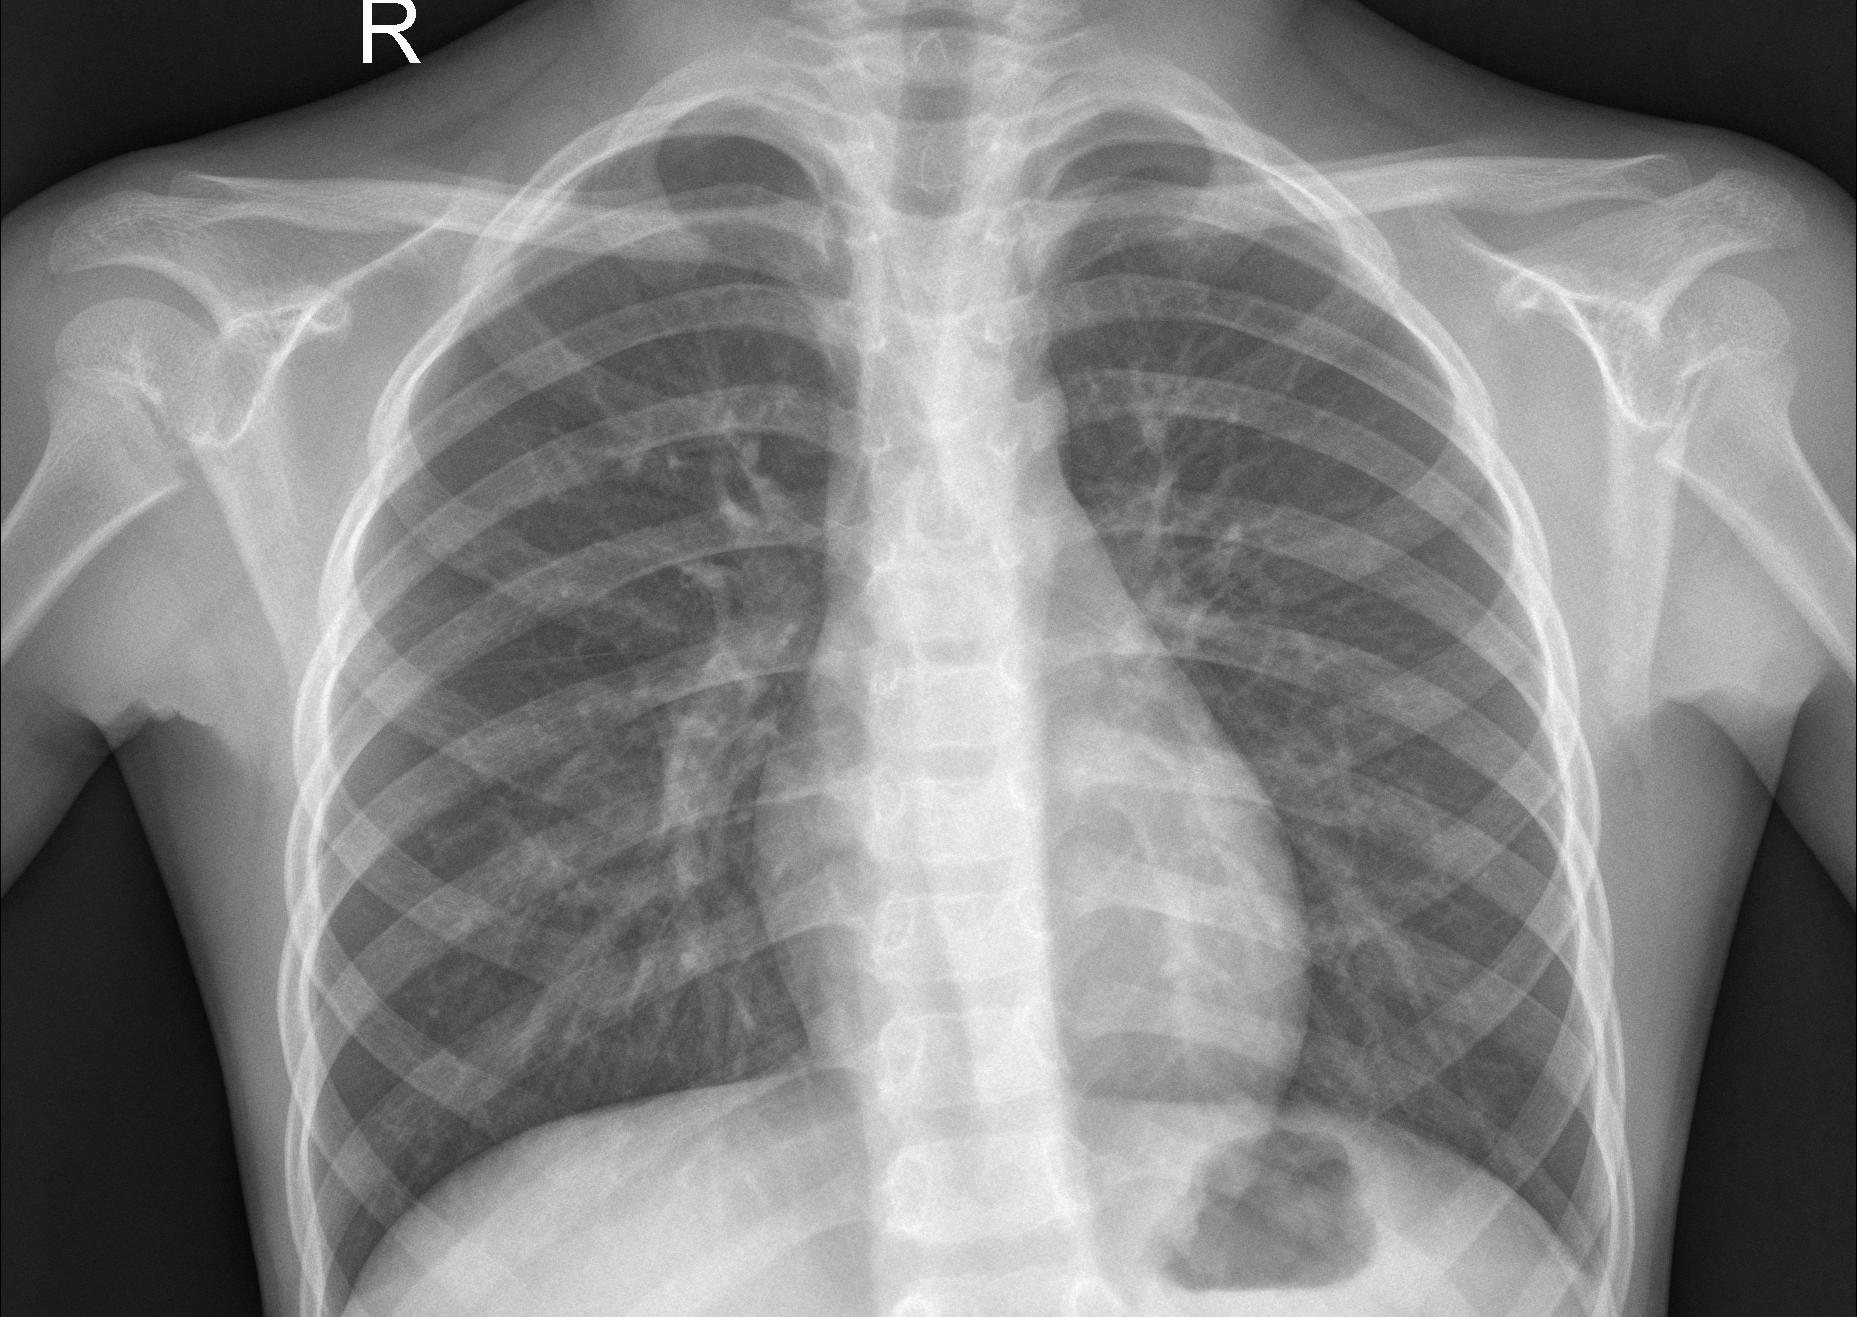

In [8]:
# trying an alternative

import PIL
from PIL import Image
image = Image.open('/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
image

# Exploratory Data Analysis (EDA)

In [9]:
dataset_path = "/content/chest_xray"
categories = ["train", "test", "val"]

for category in categories:
    class_path = os.path.join(dataset_path, category)
    print(f"\n --> {category.upper()} Set:")
    for class_name in os.listdir(class_path):
        class_folder = os.path.join(class_path, class_name)
        print(f"  - {class_name}: {len(os.listdir(class_folder))} images")


 --> TRAIN Set:
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images

 --> TEST Set:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

 --> VAL Set:
  - NORMAL: 8 images
  - PNEUMONIA: 8 images


--------------------------------------------------------------------------------

## **According to the above statistics,**

**Info about dataset balancing:**
1. The TRAIN set is imbalanced with a PNEUMONIA:NORMAL ratio of 2.89:1.
2. The TEST set is quite balanced with a PNEUMONIA:NORMAL ratio of 1.67:1
3. The VAL set is perfectly balanced with a PNEUMONIA:NORMAL ratio of 1:1.

**Info about data splitting:**

Current Split is:
- TRAIN: ~88.7%
- TEST: ~11.3%
- VAL: ~0.3% (very low)
--------------------------------------------------------------------------------

<ipython-input-10-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


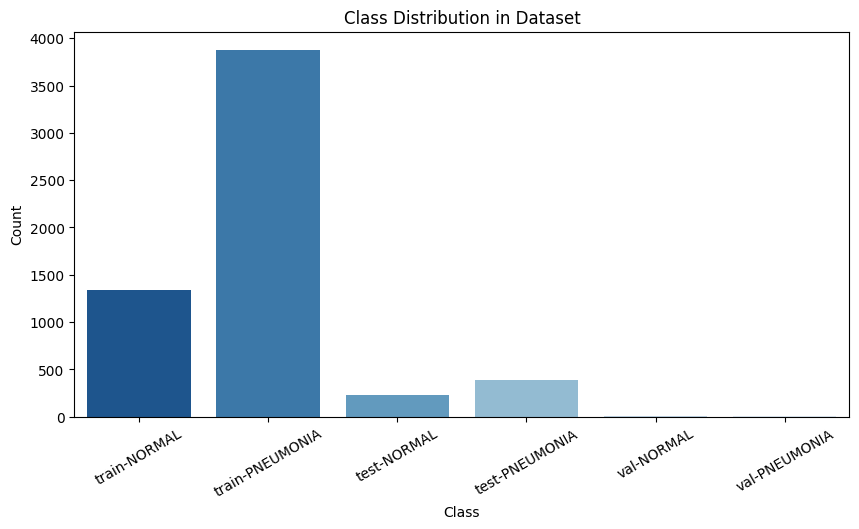

In [10]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

# Balancing the TRAIN:TEST set using data augmentation

In [11]:
normal_train_dir = "/content/chest_xray/train/NORMAL"
augmented_dir = "/content/chest_xray/train/NORMAL_AUGMENTED"

# Create directory to save augmented images
os.makedirs(augmented_dir, exist_ok=True)

# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=5,  # Reduced to avoid unnatural rotation
    width_shift_range=0.05,  # Minimized to avoid large misalignment
    height_shift_range=0.05,  # Minimized to retain lung structures
    shear_range=0.05,  # **Removed** to prevent lung distortion
    brightness_range=[0.9, 1.1],  # Helps simulate different X-ray exposures
    zoom_range=0.05,  # Small zoom-in to avoid excessive feature alteration
    fill_mode="reflect"
)

# Load all NORMAL images
normal_images = [f for f in os.listdir(normal_train_dir) if f.endswith(".jpeg")]

# Augment images to reach target count
num_augmented = 0
target_augmented = 1242  # Number of additional images needed calculated by 3875/1.5 = 2583 => 2583-1341 = 1242

for img_name in normal_images:
    if num_augmented >= target_augmented:
        break

    img_path = os.path.join(normal_train_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)

    # Generate augmented images
    aug_iter = datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix="aug", save_format="jpeg")

    for i in range(1):
        next(aug_iter)
        num_augmented += 1
        if num_augmented >= target_augmented:
            break

print(f"Successfully generated {num_augmented} augmented images in {augmented_dir}!")

Successfully generated 1242 augmented images in /content/chest_xray/train/NORMAL_AUGMENTED!


In [12]:
for img_name in os.listdir(augmented_dir):
    src = os.path.join(augmented_dir, img_name)
    dst = os.path.join(normal_train_dir, img_name)
    shutil.move(src, dst)

print("Augmented images added to NORMAL training set!")

Augmented images added to NORMAL training set!


<ipython-input-13-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


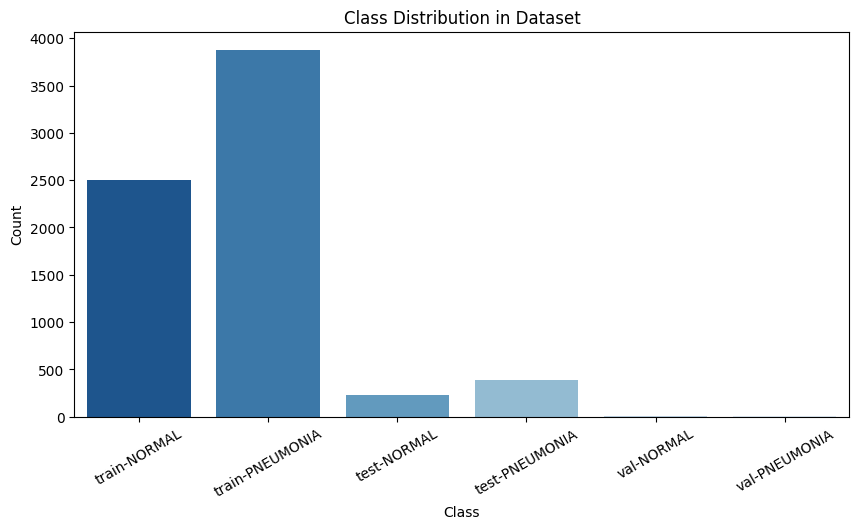

In [13]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

# Increasing the number of images in the VAL set to be around ~10%

In [14]:
normal_val_dir = "/content/chest_xray/val/NORMAL"
augmented_normal_val_dir = "/content/chest_xray/val/NORMAL_AUGMENTED"

pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA"
augmented_pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA_AUGMENTED"

os.makedirs(augmented_normal_val_dir, exist_ok=True)
os.makedirs(augmented_pneumonia_val_dir, exist_ok=True)

# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=5,  # Reduced to avoid unnatural rotation
    width_shift_range=0.05,  # Minimized to avoid large misalignment
    height_shift_range=0.05,  # Minimized to retain lung structures
    shear_range=0.05,  # **Removed** to prevent lung distortion
    brightness_range=[0.9, 1.1],  # Helps simulate different X-ray exposures
    zoom_range=0.05,  # Small zoom-in to avoid excessive feature alteration
    fill_mode="reflect"
)

normal_images = [f for f in os.listdir(normal_val_dir) if f.endswith(".jpeg")]
pneumonia_images = [f for f in os.listdir(pneumonia_val_dir) if f.endswith(".jpeg")]

target_augmented_NORMAL = 250
target_augmented_PNEUMONIA = 380

def augment_images(image_list, input_dir, output_dir, target_count):
    num_augmented = 0
    num_originals = len(image_list)

    while num_augmented < target_count:
        for img_name in image_list:
            if num_augmented >= target_count:
                break  # Stop if target reached

            img_path = os.path.join(input_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)

            # Generate multiple images per original
            aug_iter = datagen.flow(img, batch_size=1, save_to_dir=output_dir,
                                    save_prefix="aug", save_format="jpeg")

            for _ in range(target_count // num_originals + 1):  # Ensure we generate enough images
                next(aug_iter)
                num_augmented += 1
                if num_augmented >= target_count:
                    break

    print(f"Successfully generated {num_augmented} augmented images in {output_dir}!")

# **Augment NORMAL images**
augment_images(normal_images, normal_val_dir, augmented_normal_val_dir, target_augmented_NORMAL)

# **Augment PNEUMONIA images**
augment_images(pneumonia_images, pneumonia_val_dir, augmented_pneumonia_val_dir, target_augmented_PNEUMONIA)


Successfully generated 250 augmented images in /content/chest_xray/val/NORMAL_AUGMENTED!
Successfully generated 380 augmented images in /content/chest_xray/val/PNEUMONIA_AUGMENTED!


In [15]:
augmented_normal_val_dir = "/content/chest_xray/val/NORMAL_AUGMENTED"
augmented_pneumonia_val_dir = "/content/chest_xray/val/PNEUMONIA_AUGMENTED"

normal_train_dir = "/content/chest_xray/val/NORMAL"
pneumonia_train_dir = "/content/chest_xray/val/PNEUMONIA"

for img_name in os.listdir(augmented_normal_val_dir):
    src = os.path.join(augmented_normal_val_dir, img_name)
    dst = os.path.join(normal_train_dir, img_name)
    shutil.move(src, dst)

print(f"Successfully moved augmented NORMAL images to {normal_train_dir}!")

for img_name in os.listdir(augmented_pneumonia_val_dir):
    src = os.path.join(augmented_pneumonia_val_dir, img_name)
    dst = os.path.join(pneumonia_train_dir, img_name)
    shutil.move(src, dst)

print(f"Successfully moved augmented PNEUMONIA images to {pneumonia_train_dir}!")

Successfully moved augmented NORMAL images to /content/chest_xray/val/NORMAL!
Successfully moved augmented PNEUMONIA images to /content/chest_xray/val/PNEUMONIA!


<ipython-input-16-445c1dcbee4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


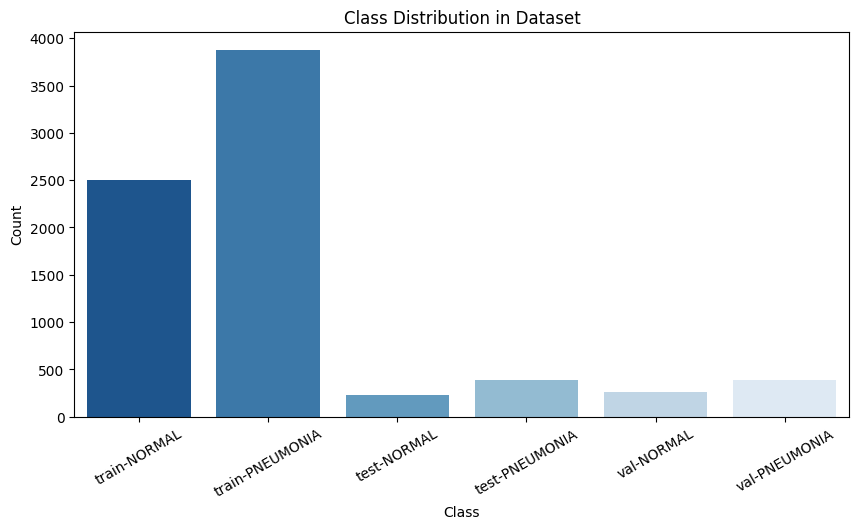

In [16]:
# Count images per class
class_counts = {"Class": [], "Count": []}
for category in ["train", "test", "val"]:
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(dataset_path, category, class_name)
        class_counts["Class"].append(f"{category}-{class_name}")
        class_counts["Count"].append(len(os.listdir(class_path)))

df = pd.DataFrame(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=30)
plt.title("Class Distribution in Dataset")
plt.show()

In [17]:
dataset_path = "/content/chest_xray"
categories = ["train", "test", "val"]

for category in categories:
    class_path = os.path.join(dataset_path, category)
    print(f"\n --> {category.upper()} Set:")
    for class_name in os.listdir(class_path):
        class_folder = os.path.join(class_path, class_name)
        print(f"  - {class_name}: {len(os.listdir(class_folder))} images")


 --> TRAIN Set:
  - NORMAL: 2503 images
  - NORMAL_AUGMENTED: 0 images
  - PNEUMONIA: 3875 images

 --> TEST Set:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

 --> VAL Set:
  - NORMAL: 256 images
  - PNEUMONIA_AUGMENTED: 0 images
  - NORMAL_AUGMENTED: 0 images
  - PNEUMONIA: 386 images


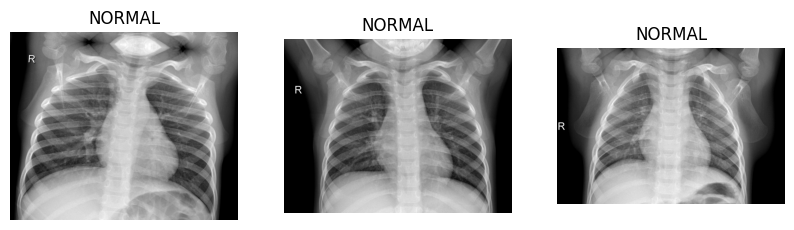

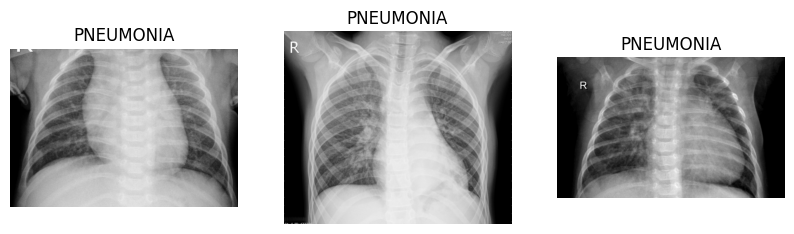

In [18]:
import random

def show_sample_images(category, num_samples=3):
    class_path = os.path.join(dataset_path, "train", category)
    images = random.sample(os.listdir(class_path), num_samples)

    plt.figure(figsize=(10, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb, cmap='gray')
        plt.title(category)
        plt.axis("off")

    plt.show()

show_sample_images("NORMAL")
show_sample_images("PNEUMONIA")

-----------------------------------------------
## **Some Observations:**

- The images are sharp and clear, with visible anatomical structures. This is good for diagnostic purposes.

- The normal cases have clear lung fields, while the pneumonia cases exhibit hazy opacities or white patches, indicating fluid or inflammation. These differences are noticeable.

- While the images are distinguishable, some pneumonia cases seem slightly darker, which could make finer details harder to distinguish. Adjusting brightness and contrast might enhance the visibility of the patterns.
-----------------------------------------------

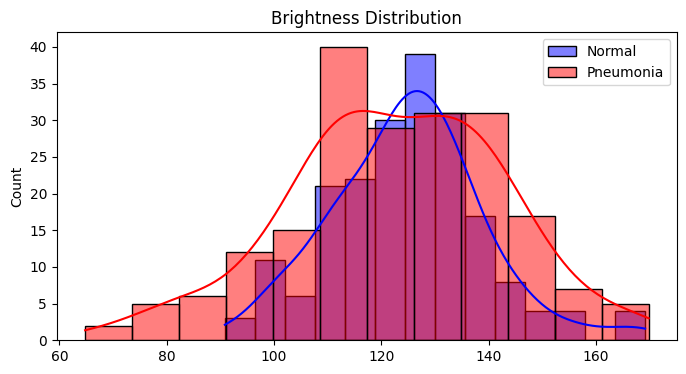

In [19]:
import numpy as np

def calculate_brightness(img):
    return np.mean(img)

brightness_values = {"NORMAL": [], "PNEUMONIA": []}

for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:  # Sample 200 images
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        brightness_values[category].append(calculate_brightness(img))

# Plot brightness distribution
plt.figure(figsize=(8, 4))
sns.histplot(brightness_values["NORMAL"], color="blue", label="Normal", kde=True)
sns.histplot(brightness_values["PNEUMONIA"], color="red", label="Pneumonia", kde=True)
plt.legend()
plt.title("Brightness Distribution")
plt.show()

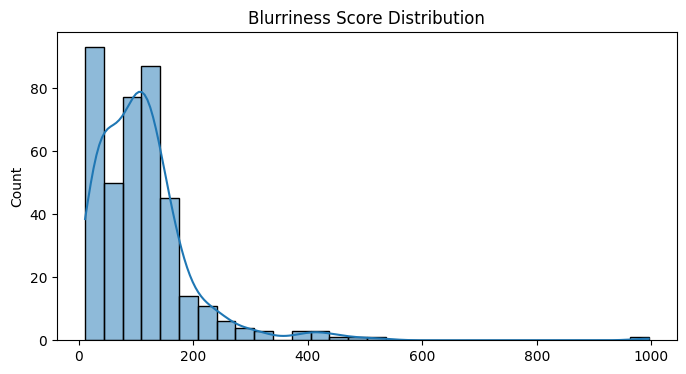

In [20]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

blurriness_scores = []
for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:
        img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
        blurriness_scores.append(variance_of_laplacian(img))

plt.figure(figsize=(8, 4))
sns.histplot(blurriness_scores, bins=30, kde=True)
plt.title("Blurriness Score Distribution")
plt.show()

In [21]:
import numpy as np

img_shapes = []
for category in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(dataset_path, "train", category)
    for img_name in os.listdir(class_path)[:200]:  # Sample 200 images
        img = cv2.imread(os.path.join(class_path, img_name))
        img_shapes.append(img.shape)

img_shapes = np.array(img_shapes)
print("Unique Image Shapes:", np.unique(img_shapes, axis=0))

Unique Image Shapes: [[ 172  428    3]
 [ 173  448    3]
 [ 186  486    3]
 ...
 [2411 2318    3]
 [2540 2428    3]
 [2583 2916    3]]


-----------------------------------------------
##### All images are of different shapes. Thus, resizing is required.
-----------------------------------------------

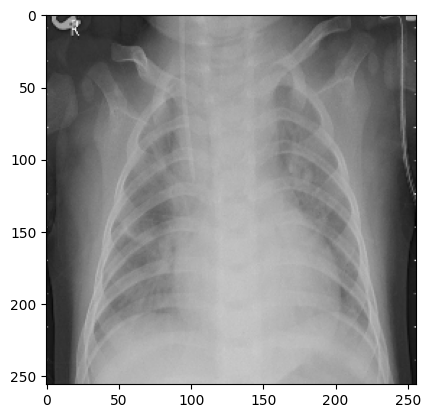

In [22]:
#Resizing

resized = cv2.resize(img, (256,256))
resized.shape
plt.imshow(resized)

In [23]:
# Normalizing the pixel Values

normalized = resized / 255.0
normalized

array([[[0.17254902, 0.17254902, 0.17254902],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216],
        ...,
        [0.59215686, 0.59215686, 0.59215686],
        [0.60784314, 0.60784314, 0.60784314],
        [0.61960784, 0.61960784, 0.61960784]],

       [[0.18039216, 0.18039216, 0.18039216],
        [0.16862745, 0.16862745, 0.16862745],
        [0.16078431, 0.16078431, 0.16078431],
        ...,
        [0.62352941, 0.62352941, 0.62352941],
        [0.62352941, 0.62352941, 0.62352941],
        [0.62352941, 0.62352941, 0.62352941]],

       [[0.17647059, 0.17647059, 0.17647059],
        [0.17647059, 0.17647059, 0.17647059],
        [0.16862745, 0.16862745, 0.16862745],
        ...,
        [0.61960784, 0.61960784, 0.61960784],
        [0.62352941, 0.62352941, 0.62352941],
        [0.61176471, 0.61176471, 0.61176471]],

       ...,

       [[0.10588235, 0.10588235, 0.10588235],
        [0.10588235, 0.10588235, 0.10588235],
        [0.10980392, 0

In [24]:
#standarizing the images

mean = np.mean(normalized)
std = np.std(normalized)

standardized = (normalized - mean) / std

print("Mean after standardization:", np.mean(standardized))
print("Std after standardization:", np.std(standardized))

Mean after standardization: 1.295260195396016e-16
Std after standardization: 1.0


In [26]:
shutil.rmtree('/content/chest_xray/train/NORMAL_AUGMENTED', ignore_errors=True)
shutil.rmtree('/content/chest_xray/val/NORMAL_AUGMENTED', ignore_errors=True)
shutil.rmtree('/content/chest_xray/val/PNEUMONIA_AUGMENTED', ignore_errors=True)

# Building the CNN Model using Transfer Learning

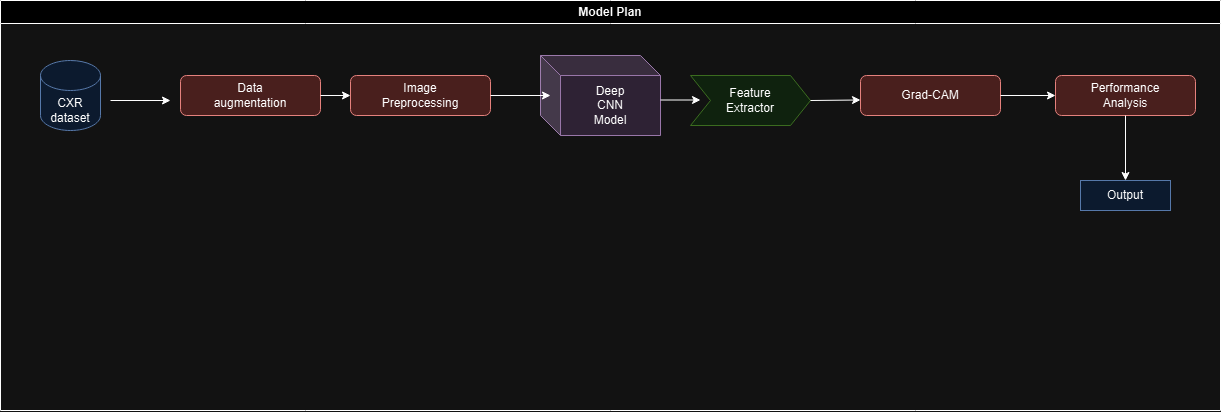

## ResNet - 50

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [30]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (Pneumonia vs Normal)

model = Model(inputs=base_model.input, outputs=output)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

print("Classes in train:", train_generator.class_indices)
print("Classes in val:", val_generator.class_indices)

Found 6378 images belonging to 2 classes.
Found 642 images belonging to 2 classes.
Classes in train: {'NORMAL': 0, 'PNEUMONIA': 1}
Classes in val: {'NORMAL': 0, 'PNEUMONIA': 1}


In [32]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 108s 456ms/step - accuracy: 0.5614 - loss: 0.7237 - val_accuracy: 0.6012 - val_loss: 0.6398
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.6333 - loss: 0.6363 - val_accuracy: 0.6682 - val_loss: 0.5854
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 384ms/step - accuracy: 0.7361 - loss: 0.5364 - val_accuracy: 0.6822 - val_loss: 0.5140
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 377ms/step - accuracy: 0.8020 - loss: 0.4528 - val_accuracy: 0.6745 - val_loss: 0.5321
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 365ms/step - accuracy: 0.8249 - loss: 0.4072 - val_accuracy: 0.6760 - val_loss: 0.5599
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 363ms/step - accuracy: 0.8381 - loss: 0.3860 - val_accuracy: 0.6854 - val_loss: 0.6568
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 369ms/step - accuracy: 0.8446 - loss: 0.3709 - val_accuracy: 0.6854 - val_loss: 0.6702
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 365ms/step - accuracy: 0.8336 - loss: 

In [43]:
model.save("pneumonia_model.h5")

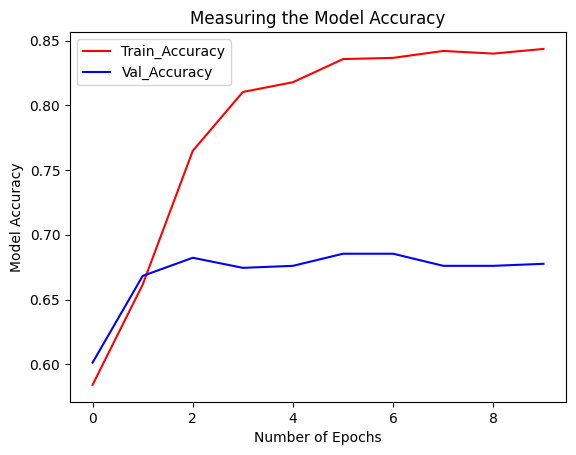

In [33]:
plt.plot(history.history['accuracy'],color='r',label='Train_Accuracy')
plt.plot(history.history['val_accuracy'],color='b',label='Val_Accuracy')
plt.title('Measuring the Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Accuracy')
plt.legend()
plt.show()

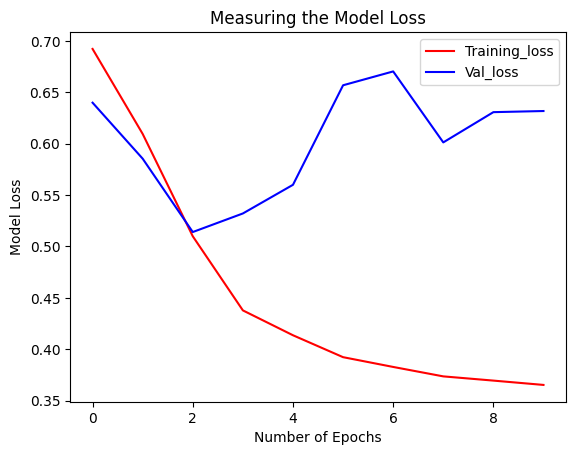

In [34]:
plt.plot(history.history['loss'],color='r',label='Training_loss')
plt.plot(history.history['val_loss'],color='b',label='Val_loss')
plt.title('Measuring the Model Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.show()

### Grad-CAM Analysis

Saved: /content/chest_xray_gradcam/NORMAL/NORMAL2-IM-0567-0001.jpeg


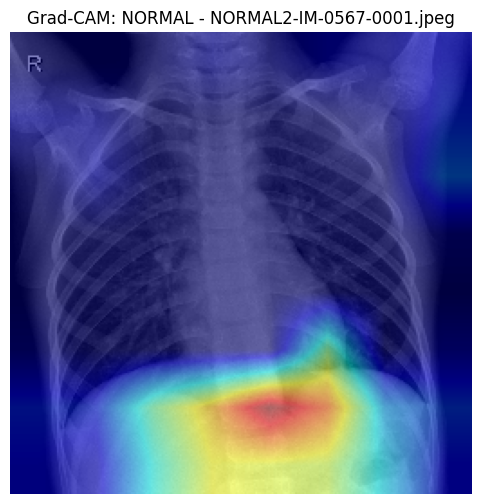

Saved: /content/chest_xray_gradcam/NORMAL/aug_0_9834.jpeg


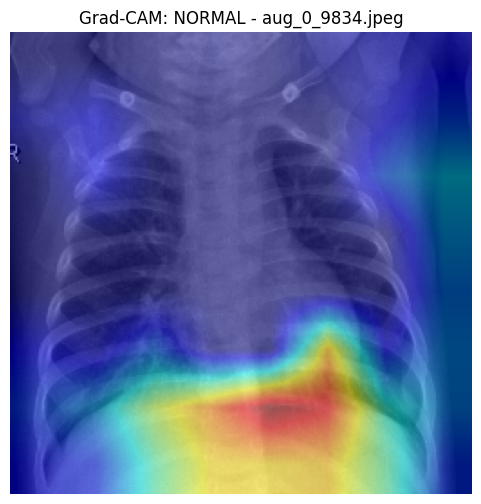

Saved: /content/chest_xray_gradcam/NORMAL/aug_0_8222.jpeg


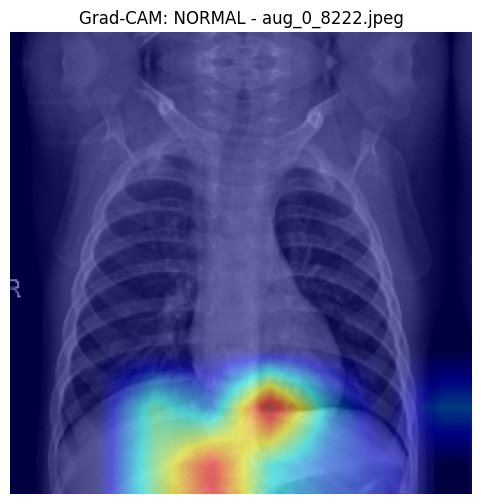

Saved: /content/chest_xray_gradcam/NORMAL/IM-0650-0001.jpeg


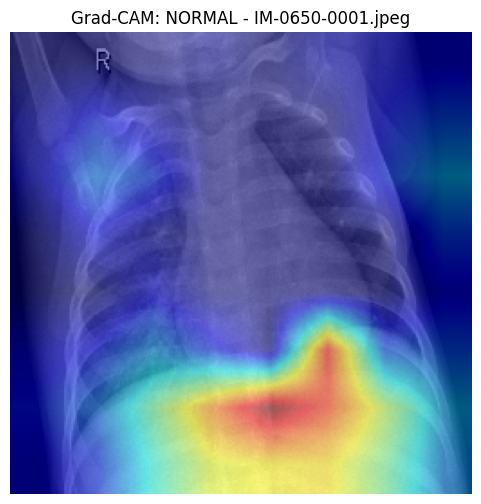

Saved: /content/chest_xray_gradcam/NORMAL/NORMAL2-IM-1001-0001.jpeg


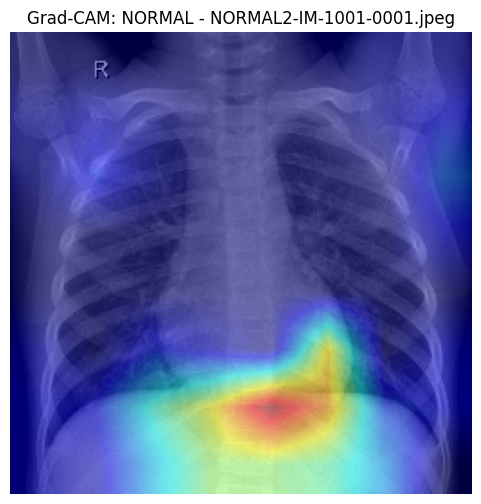

Saved: /content/chest_xray_gradcam/PNEUMONIA/person1366_virus_2349.jpeg


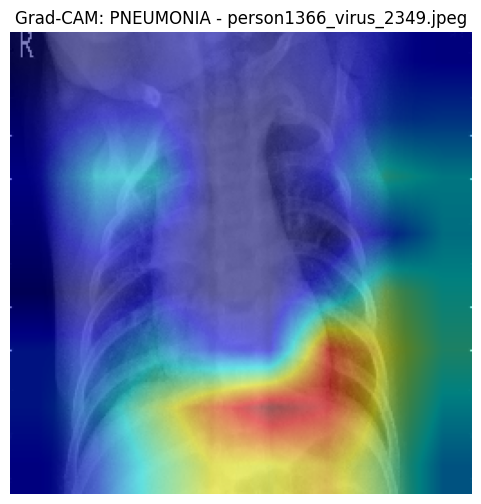

Saved: /content/chest_xray_gradcam/PNEUMONIA/person647_virus_1229.jpeg


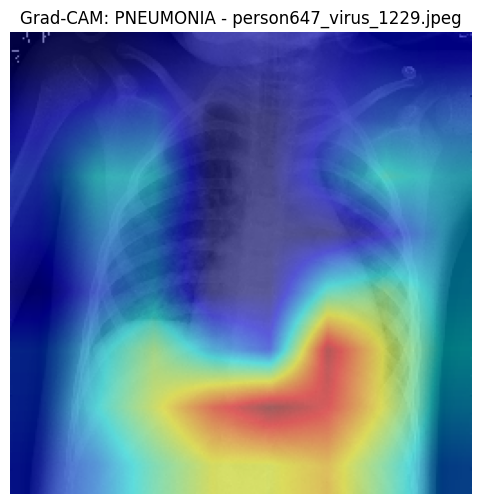

Saved: /content/chest_xray_gradcam/PNEUMONIA/person540_virus_1070.jpeg


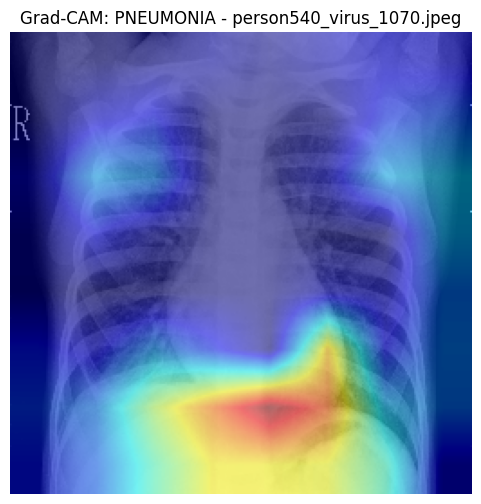

Saved: /content/chest_xray_gradcam/PNEUMONIA/person1639_bacteria_4347.jpeg


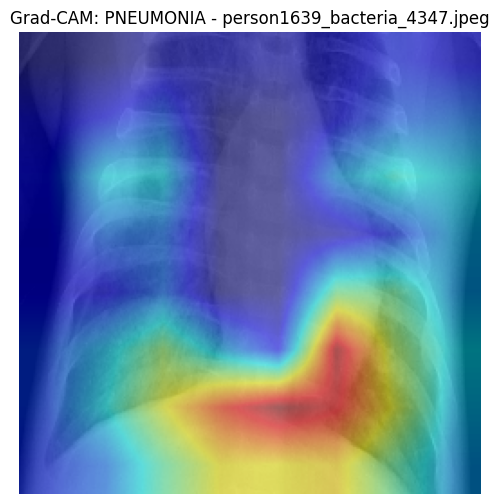

Saved: /content/chest_xray_gradcam/PNEUMONIA/person371_bacteria_1694.jpeg


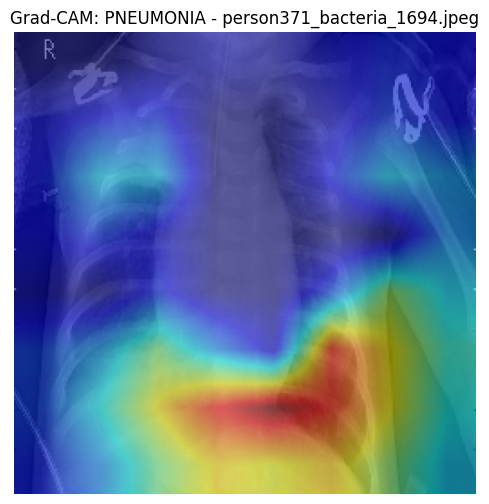

In [40]:
# 🛠️ Function to generate Grad-CAM heatmap
def generate_gradcam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]  # Focus on the most confident class

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check the input image and model.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Handle NaN and normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap = np.squeeze(heatmap)  # Remove batch dimension
    heatmap = np.nan_to_num(heatmap)  # Replace NaNs

    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# 🛠️ Function to overlay heatmap on the original image
def overlay_heatmap(img, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)

    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for visualization

# 🛠️ Function to preprocess an image
def preprocess_image(image_path, img_size=(256, 256)):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    return img_array, np.uint8(img_array[0] * 255)  # Return preprocessed and original image

# 🛠️ Function to process the entire dataset
def process_dataset(model, dataset_path, layer_name, output_path):
    categories = ["NORMAL", "PNEUMONIA"]  # Modify if more classes exist
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only process image files
                image_path = os.path.join(input_folder, filename)
                img_array, original_img = preprocess_image(image_path)

                try:
                    heatmap = generate_gradcam(model, img_array, layer_name)
                    superimposed_img = overlay_heatmap(original_img, heatmap)

                    # Save the processed image
                    output_file = os.path.join(output_folder, filename)
                    plt.imsave(output_file, superimposed_img)
                    print(f"Saved: {output_file}")
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# 🛠️ Function to process a few selected samples
def process_few_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all images and randomly select num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save and show the image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Display the image
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# 🛠️ Function to process specific images manually
def process_specific_images(model, image_paths, layer_name):
    for image_path in image_paths:
        img_array, original_img = preprocess_image(image_path)

        try:
            heatmap = generate_gradcam(model, img_array, layer_name)
            superimposed_img = overlay_heatmap(original_img, heatmap)

            # Show the image
            plt.figure(figsize=(6, 6))
            plt.imshow(superimposed_img)
            plt.axis('off')
            plt.title(f"Grad-CAM: {os.path.basename(image_path)}")
            plt.show()

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# 🎯 Example Usage
dataset_path = "/content/chest_xray/train"  # Dataset path
output_path = "/content/chest_xray_gradcam"  # Output folder
layer_name = "conv5_block3_out"  # Target layer for Grad-CAM

# 🚀 Run for a few random samples

def process_few_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all images and randomly select num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save and show the image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Display the image
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# process_specific_images(model, sample_images, layer_name)
process_few_samples(model, dataset_path="/content/chest_xray/train",
                    layer_name="conv5_block3_out", output_path="/content/chest_xray_gradcam",
                    num_samples=5)  # Change number of samples as needed

#### Test Data

In [44]:
model = tf.keras.models.load_model("/content/pneumonia_model.h5")

# Load test images
test_dir = '/content/chest_xray/test'

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=1,  # Process one image at a time
    class_mode='binary',
    shuffle=False)  # Important for consistent predictions

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int")  # Convert to 0 or 1

# Match predictions with filenames
filenames = test_generator.filenames
for i in range(len(predicted_classes)):
    print(f"Image: {filenames[i]}, Predicted Class: {predicted_classes[i]}")


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step
Image: NORMAL/IM-0001-0001.jpeg, Predicted Class: [0]
Image: NORMAL/IM-0003-0001.jpeg, Predicted Class: [0]
Image: NORMAL/IM-0005-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0006-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0007-0001.jpeg, Predicted Class: [0]
Image: NORMAL/IM-0009-0001.jpeg, Predicted Class: [0]
Image: NORMAL/IM-0010-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0011-0001-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0011-0001-0002.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0011-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0013-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0015-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0016-0001.jpeg, Predicted Class: [0]
Image: NORMAL/IM-0017-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0019-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0021-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0022-0001.jpeg, Predicted Class: [1]
Image: NORMAL/IM-0023-0001.jp

624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6061 - loss: 0.7646


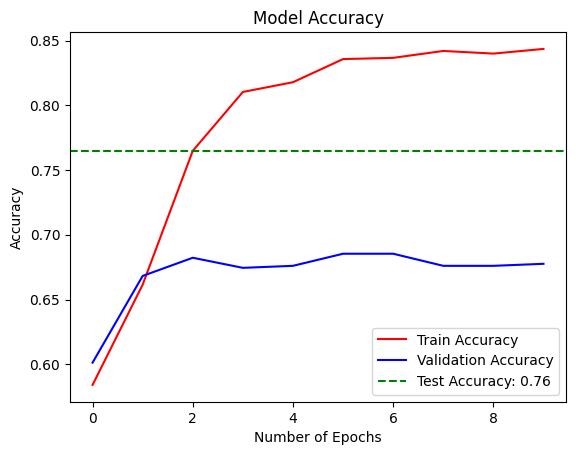

In [45]:
# graph
# 🚀 Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_generator)  # Get test loss & accuracy

# 📊 Plot train & validation accuracy
plt.plot(history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')

# 🔹 Add test accuracy as a horizontal line
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')

# 📌 Formatting
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Saved: /content/chest_xray_gradcam_test/NORMAL/NORMAL2-IM-0323-0001.jpeg


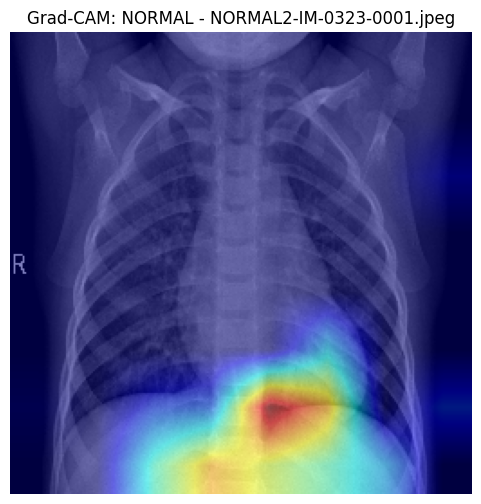

Saved: /content/chest_xray_gradcam_test/NORMAL/IM-0067-0001.jpeg


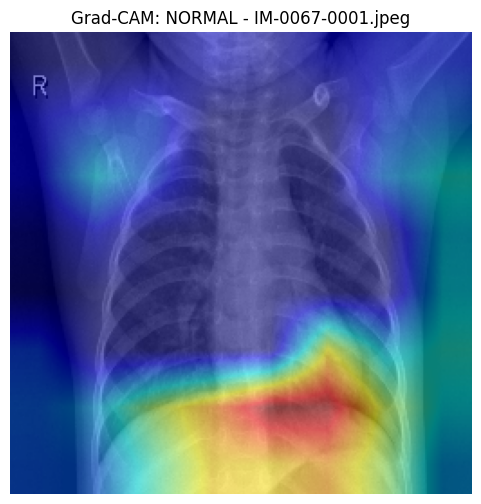

Saved: /content/chest_xray_gradcam_test/NORMAL/NORMAL2-IM-0027-0001.jpeg


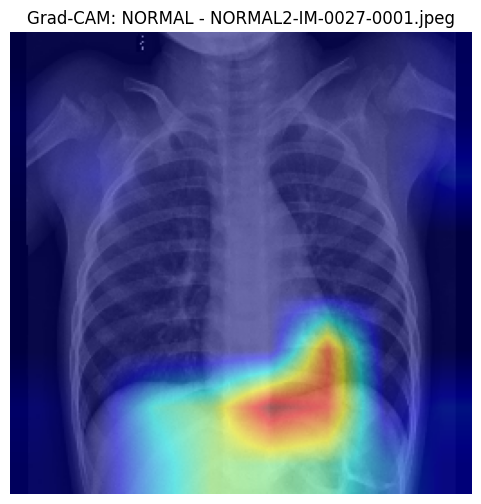

Saved: /content/chest_xray_gradcam_test/NORMAL/NORMAL2-IM-0372-0001.jpeg


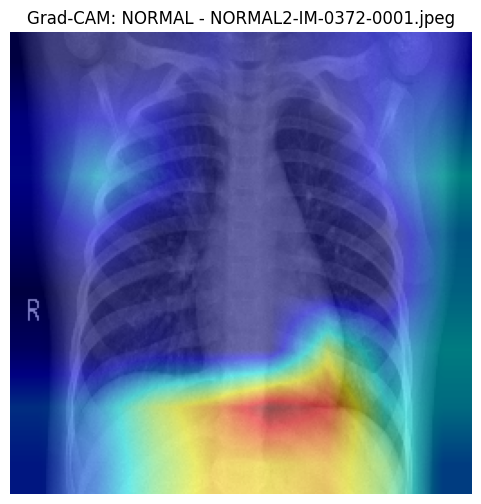

Saved: /content/chest_xray_gradcam_test/NORMAL/NORMAL2-IM-0130-0001.jpeg


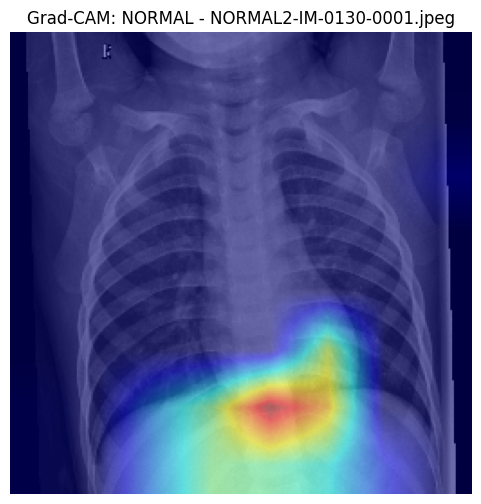

Saved: /content/chest_xray_gradcam_test/PNEUMONIA/person80_bacteria_393.jpeg


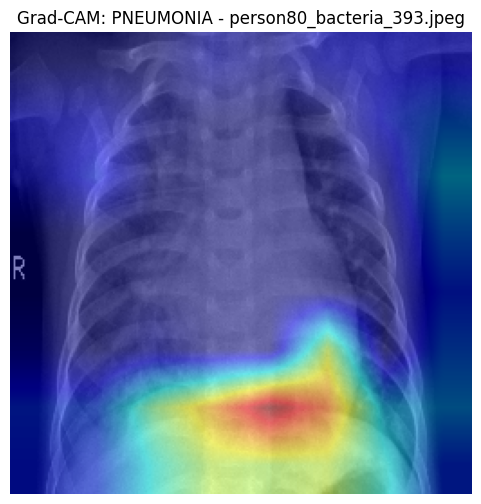

Saved: /content/chest_xray_gradcam_test/PNEUMONIA/person28_virus_63.jpeg


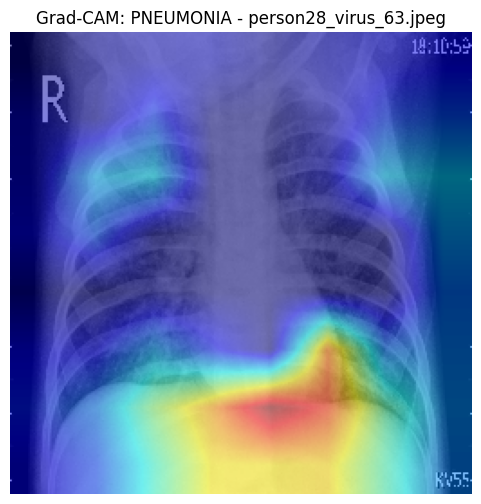

Saved: /content/chest_xray_gradcam_test/PNEUMONIA/person88_bacteria_437.jpeg


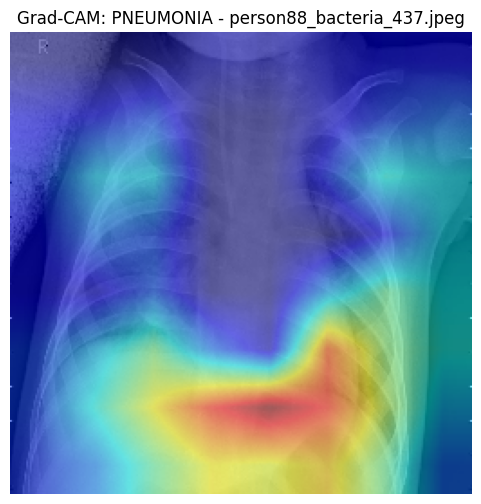

Saved: /content/chest_xray_gradcam_test/PNEUMONIA/person138_bacteria_658.jpeg


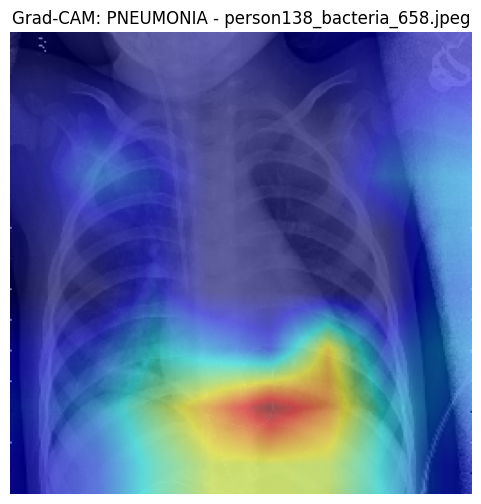

Saved: /content/chest_xray_gradcam_test/PNEUMONIA/person126_bacteria_598.jpeg


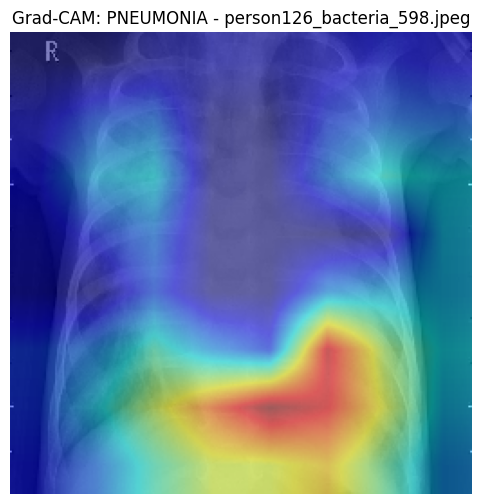

In [46]:
# 🎯 Function to process & visualize Grad-CAM for test images
def process_test_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]  # Adjust if more categories exist
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all test images & randomly pick num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save processed image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Show Grad-CAM output
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# 🎯 Run Grad-CAM for test samples
process_test_samples(model, dataset_path="/content/chest_xray/test",
                     layer_name="conv5_block3_out",
                     output_path="/content/chest_xray_gradcam_test",
                     num_samples=5)  # Change num_samples as needed

In [47]:
# Performance analysis

from sklearn.metrics import classification_report

# Get true labels & predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) > 0.5).astype("int32")

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=["Normal", "Pneumonia"]))


624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step
              precision    recall  f1-score   support

      Normal       0.74      0.57      0.64       234
   Pneumonia       0.77      0.88      0.82       390

    accuracy                           0.76       624
   macro avg       0.76      0.73      0.73       624
weighted avg       0.76      0.76      0.76       624



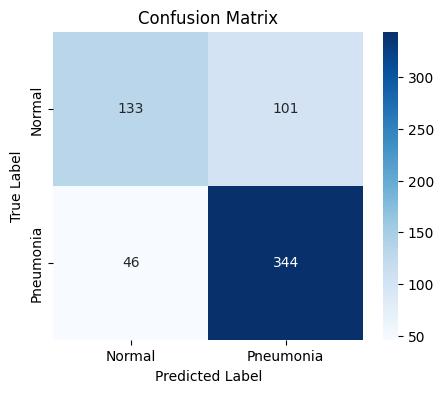

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## DenseNet - 121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load DenseNet-121 as feature extractor
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Feature extraction mode

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')

model_densenet = Model(inputs=base_model.input, outputs=output)

# Compile & train
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

print("Classes in train:", train_generator.class_indices)
print("Classes in val:", val_generator.class_indices)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

In [ ]:
model.save("pneumonia_model.h5")

In [ ]:
plt.plot(history.history['accuracy'],color='r',label='Train_Accuracy')
plt.plot(history.history['val_accuracy'],color='b',label='Val_Accuracy')
plt.title('Measuring the Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='r',label='Training_loss')
plt.plot(history.history['val_loss'],color='b',label='Val_loss')
plt.title('Measuring the Model Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.show()

In [ ]:
# 🛠️ Function to generate Grad-CAM heatmap
def generate_gradcam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]  # Focus on the most confident class

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check the input image and model.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Handle NaN and normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap = np.squeeze(heatmap)  # Remove batch dimension
    heatmap = np.nan_to_num(heatmap)  # Replace NaNs

    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# 🛠️ Function to overlay heatmap on the original image
def overlay_heatmap(img, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)

    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for visualization

# 🛠️ Function to preprocess an image
def preprocess_image(image_path, img_size=(256, 256)):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    return img_array, np.uint8(img_array[0] * 255)  # Return preprocessed and original image

# 🛠️ Function to process the entire dataset
def process_dataset(model, dataset_path, layer_name, output_path):
    categories = ["NORMAL", "PNEUMONIA"]  # Modify if more classes exist
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only process image files
                image_path = os.path.join(input_folder, filename)
                img_array, original_img = preprocess_image(image_path)

                try:
                    heatmap = generate_gradcam(model, img_array, layer_name)
                    superimposed_img = overlay_heatmap(original_img, heatmap)

                    # Save the processed image
                    output_file = os.path.join(output_folder, filename)
                    plt.imsave(output_file, superimposed_img)
                    print(f"Saved: {output_file}")
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# 🛠️ Function to process a few selected samples
def process_few_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all images and randomly select num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save and show the image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Display the image
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# 🛠️ Function to process specific images manually
def process_specific_images(model, image_paths, layer_name):
    for image_path in image_paths:
        img_array, original_img = preprocess_image(image_path)

        try:
            heatmap = generate_gradcam(model, img_array, layer_name)
            superimposed_img = overlay_heatmap(original_img, heatmap)

            # Show the image
            plt.figure(figsize=(6, 6))
            plt.imshow(superimposed_img)
            plt.axis('off')
            plt.title(f"Grad-CAM: {os.path.basename(image_path)}")
            plt.show()

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# 🎯 Example Usage
dataset_path = "/content/chest_xray/train"  # Dataset path
output_path = "/content/chest_xray_gradcam"  # Output folder
layer_name = "conv5_block3_out"  # Target layer for Grad-CAM

# 🚀 Run for a few random samples

def process_few_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all images and randomly select num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save and show the image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Display the image
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# process_specific_images(model, sample_images, layer_name)
process_few_samples(model, dataset_path="/content/chest_xray/train",
                    layer_name="conv5_block3_out", output_path="/content/chest_xray_gradcam",
                    num_samples=5)  # Change number of samples as needed

In [ ]:
#test data

model = tf.keras.models.load_model("/content/pneumonia_model.h5")

# Load test images
test_dir = '/content/chest_xray/test'

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=1,  # Process one image at a time
    class_mode='binary',
    shuffle=False)  # Important for consistent predictions

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int")  # Convert to 0 or 1

# Match predictions with filenames
filenames = test_generator.filenames
for i in range(len(predicted_classes)):
    print(f"Image: {filenames[i]}, Predicted Class: {predicted_classes[i]}")


In [ ]:
# graph
# 🚀 Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_generator)  # Get test loss & accuracy

# 📊 Plot train & validation accuracy
plt.plot(history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')

# 🔹 Add test accuracy as a horizontal line
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')

# 📌 Formatting
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Grad-CAM Analysis

In [ ]:
# 🎯 Function to process & visualize Grad-CAM for test images
def process_test_samples(model, dataset_path, layer_name, output_path, num_samples=5):
    categories = ["NORMAL", "PNEUMONIA"]  # Adjust if more categories exist
    os.makedirs(output_path, exist_ok=True)

    for category in categories:
        input_folder = os.path.join(dataset_path, category)
        output_folder = os.path.join(output_path, category)
        os.makedirs(output_folder, exist_ok=True)

        # Get all test images & randomly pick num_samples
        all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))  # Avoid index errors

        for filename in selected_images:
            image_path = os.path.join(input_folder, filename)
            img_array, original_img = preprocess_image(image_path)

            try:
                heatmap = generate_gradcam(model, img_array, layer_name)
                superimposed_img = overlay_heatmap(original_img, heatmap)

                # Save processed image
                output_file = os.path.join(output_folder, filename)
                plt.imsave(output_file, superimposed_img)
                print(f"Saved: {output_file}")

                # Show Grad-CAM output
                plt.figure(figsize=(6, 6))
                plt.imshow(superimposed_img)
                plt.axis('off')
                plt.title(f"Grad-CAM: {category} - {filename}")
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# 🎯 Run Grad-CAM for test samples
process_test_samples(model, dataset_path="/content/chest_xray/test",
                     layer_name="conv5_block3_out",
                     output_path="/content/chest_xray_gradcam_test",
                     num_samples=5)  # Change num_samples as needed

In [ ]:
# Performance analysis

from sklearn.metrics import classification_report

# Get true labels & predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) > 0.5).astype("int32")

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=["Normal", "Pneumonia"]))

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## AlexNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build AlexNet
model_alexnet = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=4, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Conv2D(256, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Conv2D(384, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(384, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile & train
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='binary_crossentropy', metrics=['accuracy'])

### Grad-CAM Analysis

In [ ]:
# ========== 3️⃣ GENERATE GRAD-CAM ==========
def generate_gradcam(model, img_array, layer_name):
    """
    Generates Grad-CAM heatmap for a given image and model.

    Parameters:
    - model: Trained model
    - img_array: Preprocessed image array (shape: (1, 256, 256, 3))
    - layer_name: Name of the last convolutional layer

    Returns:
    - heatmap: Normalized Grad-CAM heatmap
    """
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Use the predicted class

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature map with gradient importance
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap.numpy()

# ========== 4️⃣ OVERLAY HEATMAP ON IMAGE ==========
def overlay_heatmap(img, heatmap, alpha=0.5):
    """
    Overlays Grad-CAM heatmap on the original image.

    Parameters:
    - img: Original image (numpy array)
    - heatmap: Grad-CAM heatmap
    - alpha: Transparency factor

    Returns:
    - Superimposed heatmap image
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map

    # Overlay heatmap on the original image
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)

    return superimposed_img

# ========== 5️⃣ LOAD IMAGE & APPLY GRAD-CAM ==========
# Define the last convolutional layer name
layer_name = "conv5"  # Last conv layer in DenseNet121

# Load and preprocess image
img_path = "sample_cxr.jpg"  # Change this to your image path
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model_densenet, img_array, layer_name)

# Overlay heatmap
superimposed_img = overlay_heatmap(original_img, heatmap)

# ========== 6️⃣ DISPLAY RESULTS ==========
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.axis('off')
plt.title("Original Image")

# Grad-CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM Heatmap")

plt.show()

## Vision Transformer (ViT-B/16)

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

# Load ViT model
model_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                       num_labels=1)  # Binary classification

# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

### Attention Rollout

In [ ]:
from transformers import ViTModel
import torch

# Load ViT model
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

def attention_rollout(attention_maps, discard_ratio=0.9):
    """Computes class-specific attention visualization for ViTs."""
    attn = torch.mean(attention_maps, dim=1)  # Average attention over heads
    attn = attn[:, 1:, 1:]  # Remove CLS token
    attn = attn.sum(dim=0)  # Aggregate across layers
    attn = attn / attn.max()  # Normalize

    return attn.cpu().detach().numpy()

# Extract attention maps
with torch.no_grad():
    outputs = model(your_xray_image, output_attentions=True)
    attention_maps = outputs.attentions

# Generate attention visualization
heatmap = attention_rollout(attention_maps)

## GoogleNet

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = False  # Feature extraction mode

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')

model_googlenet = Model(inputs=base_model.input, outputs=output)

# Compile & train
model_googlenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss='binary_crossentropy', metrics=['accuracy'])

### Grad-CAM Analysis

In [ ]:
# ========== 3️⃣ GENERATE GRAD-CAM ==========
def generate_gradcam(model, img_array, layer_name):
    """
    Generates Grad-CAM heatmap for a given image and model.

    Parameters:
    - model: Trained model
    - img_array: Preprocessed image array (shape: (1, 256, 256, 3))
    - layer_name: Name of the last convolutional layer

    Returns:
    - heatmap: Normalized Grad-CAM heatmap
    """
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Use the predicted class

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature map with gradient importance
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap.numpy()

# ========== 4️⃣ OVERLAY HEATMAP ON IMAGE ==========
def overlay_heatmap(img, heatmap, alpha=0.5):
    """
    Overlays Grad-CAM heatmap on the original image.

    Parameters:
    - img: Original image (numpy array)
    - heatmap: Grad-CAM heatmap
    - alpha: Transparency factor

    Returns:
    - Superimposed heatmap image
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map

    # Overlay heatmap on the original image
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)

    return superimposed_img

# ========== 5️⃣ LOAD IMAGE & APPLY GRAD-CAM ==========
# Define the last convolutional layer name
layer_name = "mixed10"  # Last conv layer in DenseNet121

# Load and preprocess image
img_path = "sample_cxr.jpg"  # Change this to your image path
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model_densenet, img_array, layer_name)

# Overlay heatmap
superimposed_img = overlay_heatmap(original_img, heatmap)

# ========== 6️⃣ DISPLAY RESULTS ==========
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.axis('off')
plt.title("Original Image")

# Grad-CAM heatmap
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM Heatmap")

plt.show()

## One Research Paper Model

# Ensemble of Best Models